# Theory

## Simple Example

Suppose we wanted to classify the following blobs:

In [1]:
%matplotlib inline
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import numpy as np

X1, y1 = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=.5, random_state=42)
X2, y2 = make_blobs(n_samples=100, centers=3, n_features=2, cluster_std=1.5, random_state=41)

X = np.r_[X1, X2]

With k-mean clustering we perform:

Text(0.5, 1.0, 'Sample Blobs with kmean Clustering')

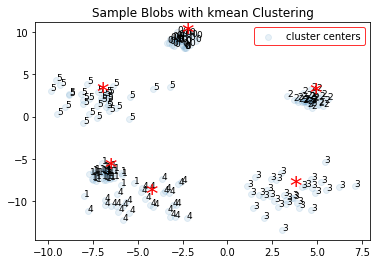

In [2]:
from sklearn.cluster import KMeans

# plot labels
kmeans = KMeans(n_clusters=6)
y_pred = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], alpha=.1)
for x_inst, pred in zip(X, y_pred):
    plt.text(x_inst[0], x_inst[1], str(pred), fontsize=9)
    
# plot cluster centers
for cc in kmeans.cluster_centers_:
    plt.text(cc[0], cc[1], '*', fontsize=25, color='red')
plt.legend(['cluster centers'], edgecolor='red')
plt.title('Sample Blobs with kmean Clustering')

We notice a few things:

* The number of clusters are known in advance. Two dimensionally, it is clear how many we should expect, but in general the answer is not so clear in higher dimensions.
* An index or ordinal number is assigned to each cluster. This is not to be confused with a label, that is in supervised machine learning.


## Cluster Space

This will help give us insights to how the algorithm actually works.

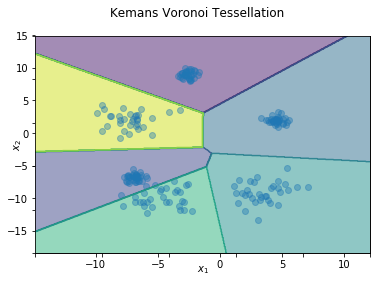

In [3]:
from mltoolbox.draw.classification import plot_2d_decision_boundary_unsupervised


plot_2d_decision_boundary_unsupervised([kmeans], X, (min(X[:, 0]) - 5, max(X[:, 0]) + 5), (min(X[:, 1]) - 5, max(X[:, 1]) + 5), 500, 500, suptitle='Kemans Voronoi Tessellation')

The result is what is called a Voronoi Tessellation. These shapes are purely a consequence from the algorithm, in terms how each instance are assigned to each cluster. In kmeans, each instance is assigned to its closest cluster center in terms of numerical distance.

The tesselation is a product of a circle expanding radially outwards from each of the cluster centers at the same rate. When a circle intersects, it draws a decision boundary. And this makes sense with the kmeans algorithm because a circle is the shorted possible path from all directions for a particular centroid. In 3 dimensions, that circle becomes a sphere, and with 3 or more dimensions that circles becomes hyper sphere.

![title](../../../../assets/2-unsupervised-learning/kmeans-tesselation.gif)

## KMeans Soft and Hard Clustering

Instead of strictly assigning each cluster to its closest cluster (hard clustering), it might be useful to assign each instance the score to each of it's clusters. _Score_ would mean whatever we want it to mean. For example, it could just be the distance of each instance to each the cluster centers. This technique can also be used as _feature engineering_ or data preprocessing technique. We can do just that by the following:

In [4]:
print('Distance to each centroid from the first 3 instances')
kmeans.transform(X[0:3, :])

Distance to each centroid from the first 3 instances


array([[17.26857745,  0.84763647, 15.26427807, 10.84471749,  3.63972927,
         9.63174065],
       [10.7850999 , 14.48782506,  0.76514467, 10.57097748, 14.92965741,
        12.3542525 ],
       [ 0.34727012, 16.7237477 , 10.3542771 , 19.39040346, 19.42587347,
         8.59312083]])

This could also be a technique for dimensionality reduction. For example, we could take a 100 dimensionsion dataset, cluster it into 5 clusters and then the cast each instance to the `transform`ation to each of these 5 cluster centers.

## Algorithm

If we had just the centroids, then we can make a classification. So the problem boils down to finding the right centroids.

### In English
1. Initialize k random centroids in space.
2. Assign each observation to its nearest centroids.
3. Recalculate each centroid as the mean of the previously assigned cluster coordinates.
4. Repeat (2-3), until cluster assignments become stable (that is, do not change from previous assignments).

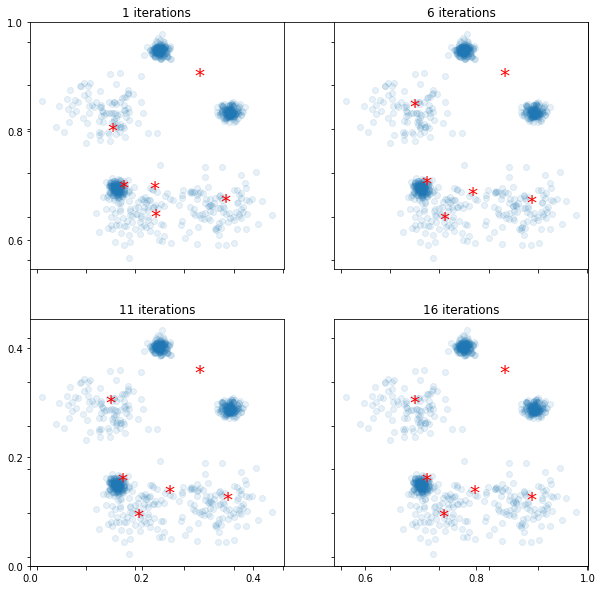

In [5]:
X1, y1 = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=.5, random_state=42)
X2, y2 = make_blobs(n_samples=300, centers=3, n_features=2, cluster_std=2, random_state=41)
X = np.r_[X1, X2]

fig, ax = plt.subplots(figsize=(10, 10))
for i, max_iter in enumerate(range(1, 20, 5), 1):
    ax = fig.add_subplot(f'{2}{2}{i}')
    kmeans = KMeans(init='random', n_clusters=6, max_iter=max_iter, n_init=1, random_state=42)
    y_pred = kmeans.fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], alpha=.1)
    for cc in kmeans.cluster_centers_:
        plt.text(cc[0], cc[1], '*', fontsize=20, color='red')
    plt.title(f"{max_iter} iterations")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

### Centroid Initialization Techniques

Because the mean squared distance of each instance to its centroid will go down each step, the algorithm is guarenteed to coverage with a finite number of steps. However, due to its random nature of centroid initialization, the algorithm can be show to yield two different solutions with different states.

To mitigate this there are some centroid initialization techniques:

1. If you happen to know where the centroids might be roughly, kmean can become initialized with it.

```python
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
```

2. A second solution is to run the algorithm several times with different initializations using `n_init`, and then just select the most optimial one. Evaluation of kmeans is discussed below.

3. There's an improved kmeans initialization (`init`) procedure known as kmeans++. This technique selects centroids that are more distance from one another. In this way, it was avoid the possibility of several centroids stacking up against one another.


### Accelerating the Algorithm

`Kmeans` also provides several `algorithm`s `elkan`, and `full`. Full is the classic algorithm explained before. `elkan` improves its performance using the triangular inequality as a way to avoid unnessessary computations. Since `elkan`'s algorithm doesn't support sparse matricies, `auto` is provided select between the two dynammically.

**`MiniBatchKMeans`**

Another variant of the KMeans algorithm is mini batching k means. This algorithm is a general improvement in terms of efficiency (3 to 4x faster), and memory management (it is capable of storing datasets that cannot fit into memory). However, the algorithm is found to nearly always have a higher `inertia` than `Kmeans`. The difference is however, generally _very small_.


```python
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)
```

## Evaluation Metrics

How does one evaluation an unsupervised system. It implies knowing what the answer is to begin with. The trick is that while we don't know what the answer is, we do know how distiguish one model to an even better model, and by how much.

The term _inertia_ (`kmeans.inertia_`) measures the total sum mean squared distance from each instance to its centroid. Inertia can be measured in the context of `Within Set Sum of Squared Error (WSSSE)` or `Within Cluster Sum of Squares (WCSS)`, which measure the distance between the centroid of a cluster and the point the cluster is assigned to.

## Finding the Optimal Number of Clusters

Naively, we can iterate through a set number of clusters and select the one with the smallest inertia right? Not so fast. With more clusters, inertia will naturally go down, and with too many cluster points - and become a case of overfitting. In fact, if you have as many clusters as there are instances, then inertia becomes zero because each centroid have a 1-1 mapping to an instance.

One technique is to follow whats called the elbow rule:

Text(0.5, 1.0, 'Inertia as a function of K')

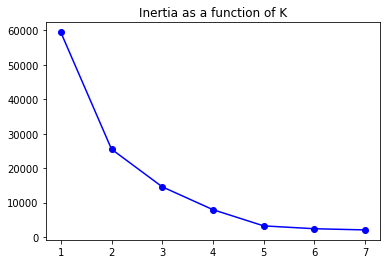

In [6]:
k_iter, inertias = list(range(1, 8)), []
for k in k_iter:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(k_iter, inertias, 'bo-')
plt.title("Inertia as a function of K")

A good choice looks like 5 since following this period, the inertia seems to plateau. This technique, while gives us some good insight, is a bit hand wavy. We'd like do something more precise and robust.

**Silhouette Score**

The silhouette score is the mean silhouette coefficient over all instances. Now zooming down in to a per-instance level, a coefficient equal $\frac{b-a}{max(a, b)}$ where

* $a$ is the mean intra-cluster distance, or the the mean distance between a datapoint and all other instances within the same cluster.
* $b$ is the mean distance between a datapoint and all the data points that is nearest to that cluster (that is not its own cluster).

![silhouette-score](../../../../assets/2-unsupervised-learning/silhouette-score.png)


Because the coefficient is a ratio over its maximum, it will be a value between -1 and 1. If the value is more positive, this indicates that the the particular data point is has a large outer cluster distance than it does inner cluster, which implies that other cluster is further away, and its pretty well zoned out from it. A value of 0 implies that the distances are equal on both ends. This particular cluster is therefore lining somewhere between the decision boundary of the other nearest cluster. And finally, a value of -1 implies that the inner distance is larger than that of the outer cluster, which could imply that there are two overlapping clusters and that this datapoint has been mislabeled.

Again, averaging all silhouette coefficients gives us the silhouette score. The interpretation from above does not change.


In [7]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.7028038323242329

Text(0.5, 1.0, 'Silhouette Score as a function of K')

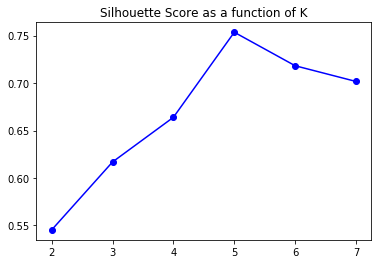

In [8]:
k_iter, ss = list(range(2, 8)), []
for k in k_iter:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    ss.append(silhouette_score(X, kmeans.labels_))
plt.plot(k_iter, ss, 'bo-')
plt.title("Silhouette Score as a function of K")

Here we can see that k=5 confirms to be good choice. With a silhouette diagram, we can even find some more interesting features.


For n_clusters = 2
The average silhouette_score is :0.5452765806830463

For n_clusters = 5
The average silhouette_score is :0.753537296721678

For n_clusters = 10
The average silhouette_score is :0.683255854734783



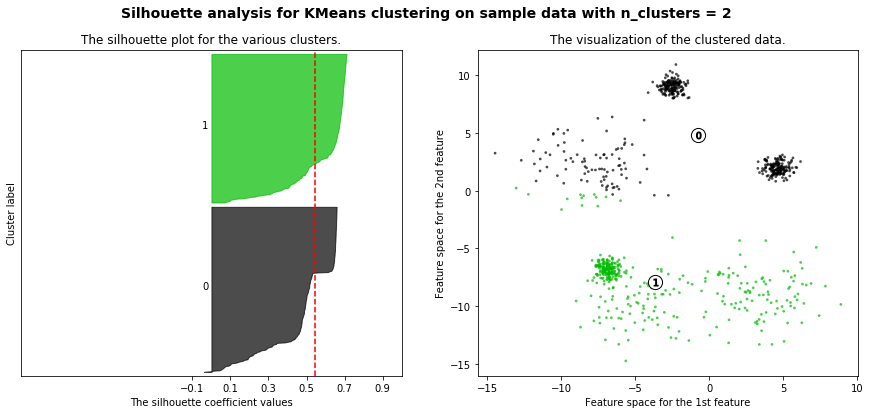

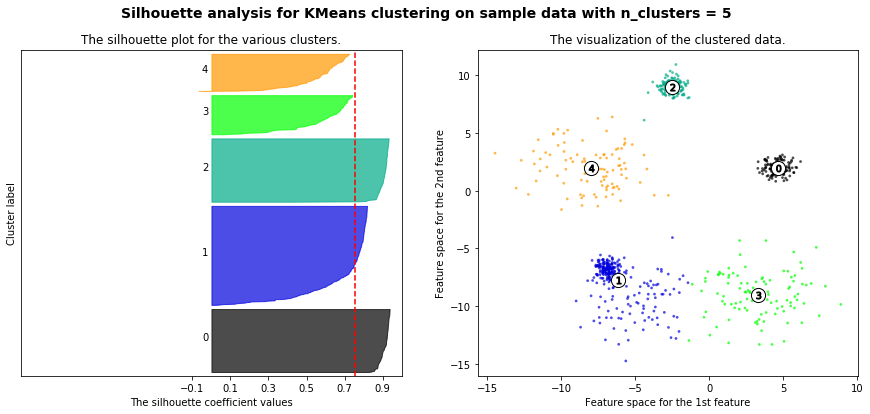

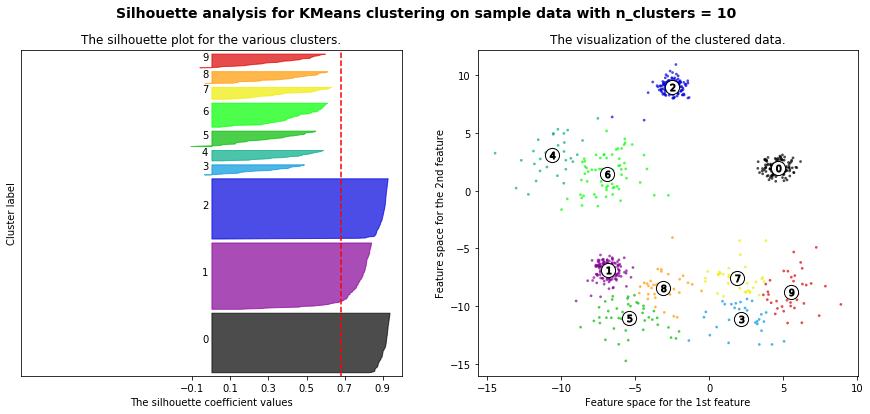

In [12]:
from mltoolbox.draw.classification import draw_silouette_diagram

draw_silouette_diagram(X, [2, 5, 10])

The average silhouette score is represented by the red dashed line, and x-axis for each of the cluster labels represents the silhouette scores for each individual clusters. The height for each of the cluster "slabs" is proporitional to the number of instances in that cluster. The slabs decreases in silhouette coefficients per instance because they are sorted (this is done mostly for asthetic reasons).

For example, the bottom diagram has a selected 10 total clusters, and the average silhouette score for these 10 clusters is around .68. Bringing this into context, we can see that with 10 clusters, clusters 3-9 are all below this average silhouette score. And mapping this clusters back onto the diagram, we can see that they are all pretty close to one another, while clusters 0-2 are not. When several clusters are close to one another like this, it's a bad sign.


## KMeans Limitations

* Kmean does not perform well when there are clusters of varying diameters. In the first case, kmeans does not care about the diameter of the clusters at all - it only cares about its cluster center and the distance a particular instance is to that cluster center. Looking back at the Tessellation plot, we can notice that with small, dense centroids, it is pretty clear for the surrounding datapoints to belong to that cluster. However, when the datapoints are more sparsely populated, because the centroid is already established, there are more edge-boundary type of cases where one point can fall under one camp or the other.

* Kmeans is also ill-preformant when there are non circular clusters largely for the same reasons as above. Also taking a look back at the gif, we can see how each there is a strong bias for circular clusters. Guassian mixture models work great against this type of issue.

* The algorithm generally runs several times to avoid suboptimal solutions.

* The number of clusters have to be specified before hand. This can add another layer of model runs to identify the correct number of clusters.

## KMeans Preprocessing Steps

* Because of the bias kmeans have with circles, it is important to first scale the input features. Otherwise, the values would be stretched creating a large degree, skewed or eliptical type circles. This is not to say that scaling the input features will make circular type clusters, but it will generally improve things.

## Time Complexity

* Average time complexity: `O(knt)`, where `k` is the number of clusters, `n` is the number of observations, and `t` is the number of iterations.
